## Example of Principal Component Analysis with the waveforms

This example builds on top of the previous tutorial (https://github.com/maciekszul/burst_detection/blob/main/superlet_burst_detection_example.ipynb) so some of the steps described there will be omitted or simplified.

In [4]:
import numpy as np
import pandas as pd
from matplotlib import ticker
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from burst_detection import extract_bursts

#### The cell below is a pseudocode representation of the burst detection (details are described in burst detection tutorial), the purpose of this example is to show one way to add specific details to the data output and combine it all to a usable dataset for further analysis.

In [ ]:
freqs = foi # taken from superlet trasformation
search_range = np.where((freqs >= 10) & (freqs <= 33))[0]
beta_lims = [13, 30]
ap_threshold = 10**ff._ap_fit[search_range] # aperiodic fit from FOOOF and limited to the freqiencies of interest

burtst_all_results = []
for sensor in range(10):
    bursts = extract_bursts(
        epoch[:,sensor,:], tf[:, sensor, search_range], times,
        freqs[search_range], beta_lims, ap_threshold.reshape(-1,1), sfreq
    )
    bursts["sensor"] = np.tile(sensor, bursts["trial"].shape)
    bursts["subject"] = np.tile(subject, bursts["trial"].shape)
    bursts_all_results.append(bursts)

waveform_times = bursts_all_results[0]["waveform_time"]

#### Here we will combine burst features into a single data frame, and waveforms into a separate array. The first dimensions of the data frame and array are same, so boolean array based on e.g. "sensor" column can be used on the waveform array.

In [ ]:
dict_output = {i: [] for i in burtst_all_results[0].keys() if not many_is_in(["waveform", "waveform_times"], i)}
waveforms = []

for b in burtst_all_results:
    [dict_output[k].append(b[k]) for k in dict_output.keys()];
    waveforms.append(b["waveform"])

for i in dict_output.keys():
    dict_output[i] = np.hstack(dict_output[i])
waveforms = np.vstack([i for i in waveforms if i.shape[0] > 0]) # all the bursts x time

#### Selecting bursts between 0.5 percentile and 99.5 percentile of max amplitude to limit the impact of outliers on model fit. Then taking a random 50% of bursts of that

In [8]:
amp_max = np.max(waveforms, axis=1)
amp_map = (amp_max >= np.percentile(amp_max, 0.5)) & (amp_max <= np.percentile(amp_max, 99.5))
pca_subset = np.random.choice(np.arange(amp_max.shape[0])[amp_map], size=int(amp_max.shape[0]*0.5))

#### Fit scaler and model on a subset of bursts, and transform the full waveform array to component scores.

In [9]:
model = PCA(n_components=20)
scaler = RobustScaler().fit(waveforms[pca_subset])
model.fit(scaler.transform(waveforms[pca_subset]))
pc_scores = model.transform(waveforms) # all the bursts x 20 components 

#### Here we integrating the PCA scores with the burst features data frame. Waveforms array and data frame can be saved.

In [12]:
pc_labels = ["PC_{}".format(i+1) for i in range(pc_scores.shape[1])]
pc_df = pd.DataFrame.from_dict({i: pc_scores[:,ix] for ix, i in enumerate(pc_labels)})
features_scores = pd.concat([dict_output, pc_df], axis=1)

np.save("waveforms.npy", waveforms)
features_scores.to_csv("burst_features_scores.csv", index=None)

#### The PC scores can be analysed in many ways. Simple example here illustrates the principles of selecting the waveforms based on the dataframe. See the paper (https://doi.org/10.1016/j.pneurobio.2023.102490) for different ways the pc score was employed.

Here each burst PC score will be divided into quartiles and based on this selection, the average waveform from each quintile is going to be plotted.

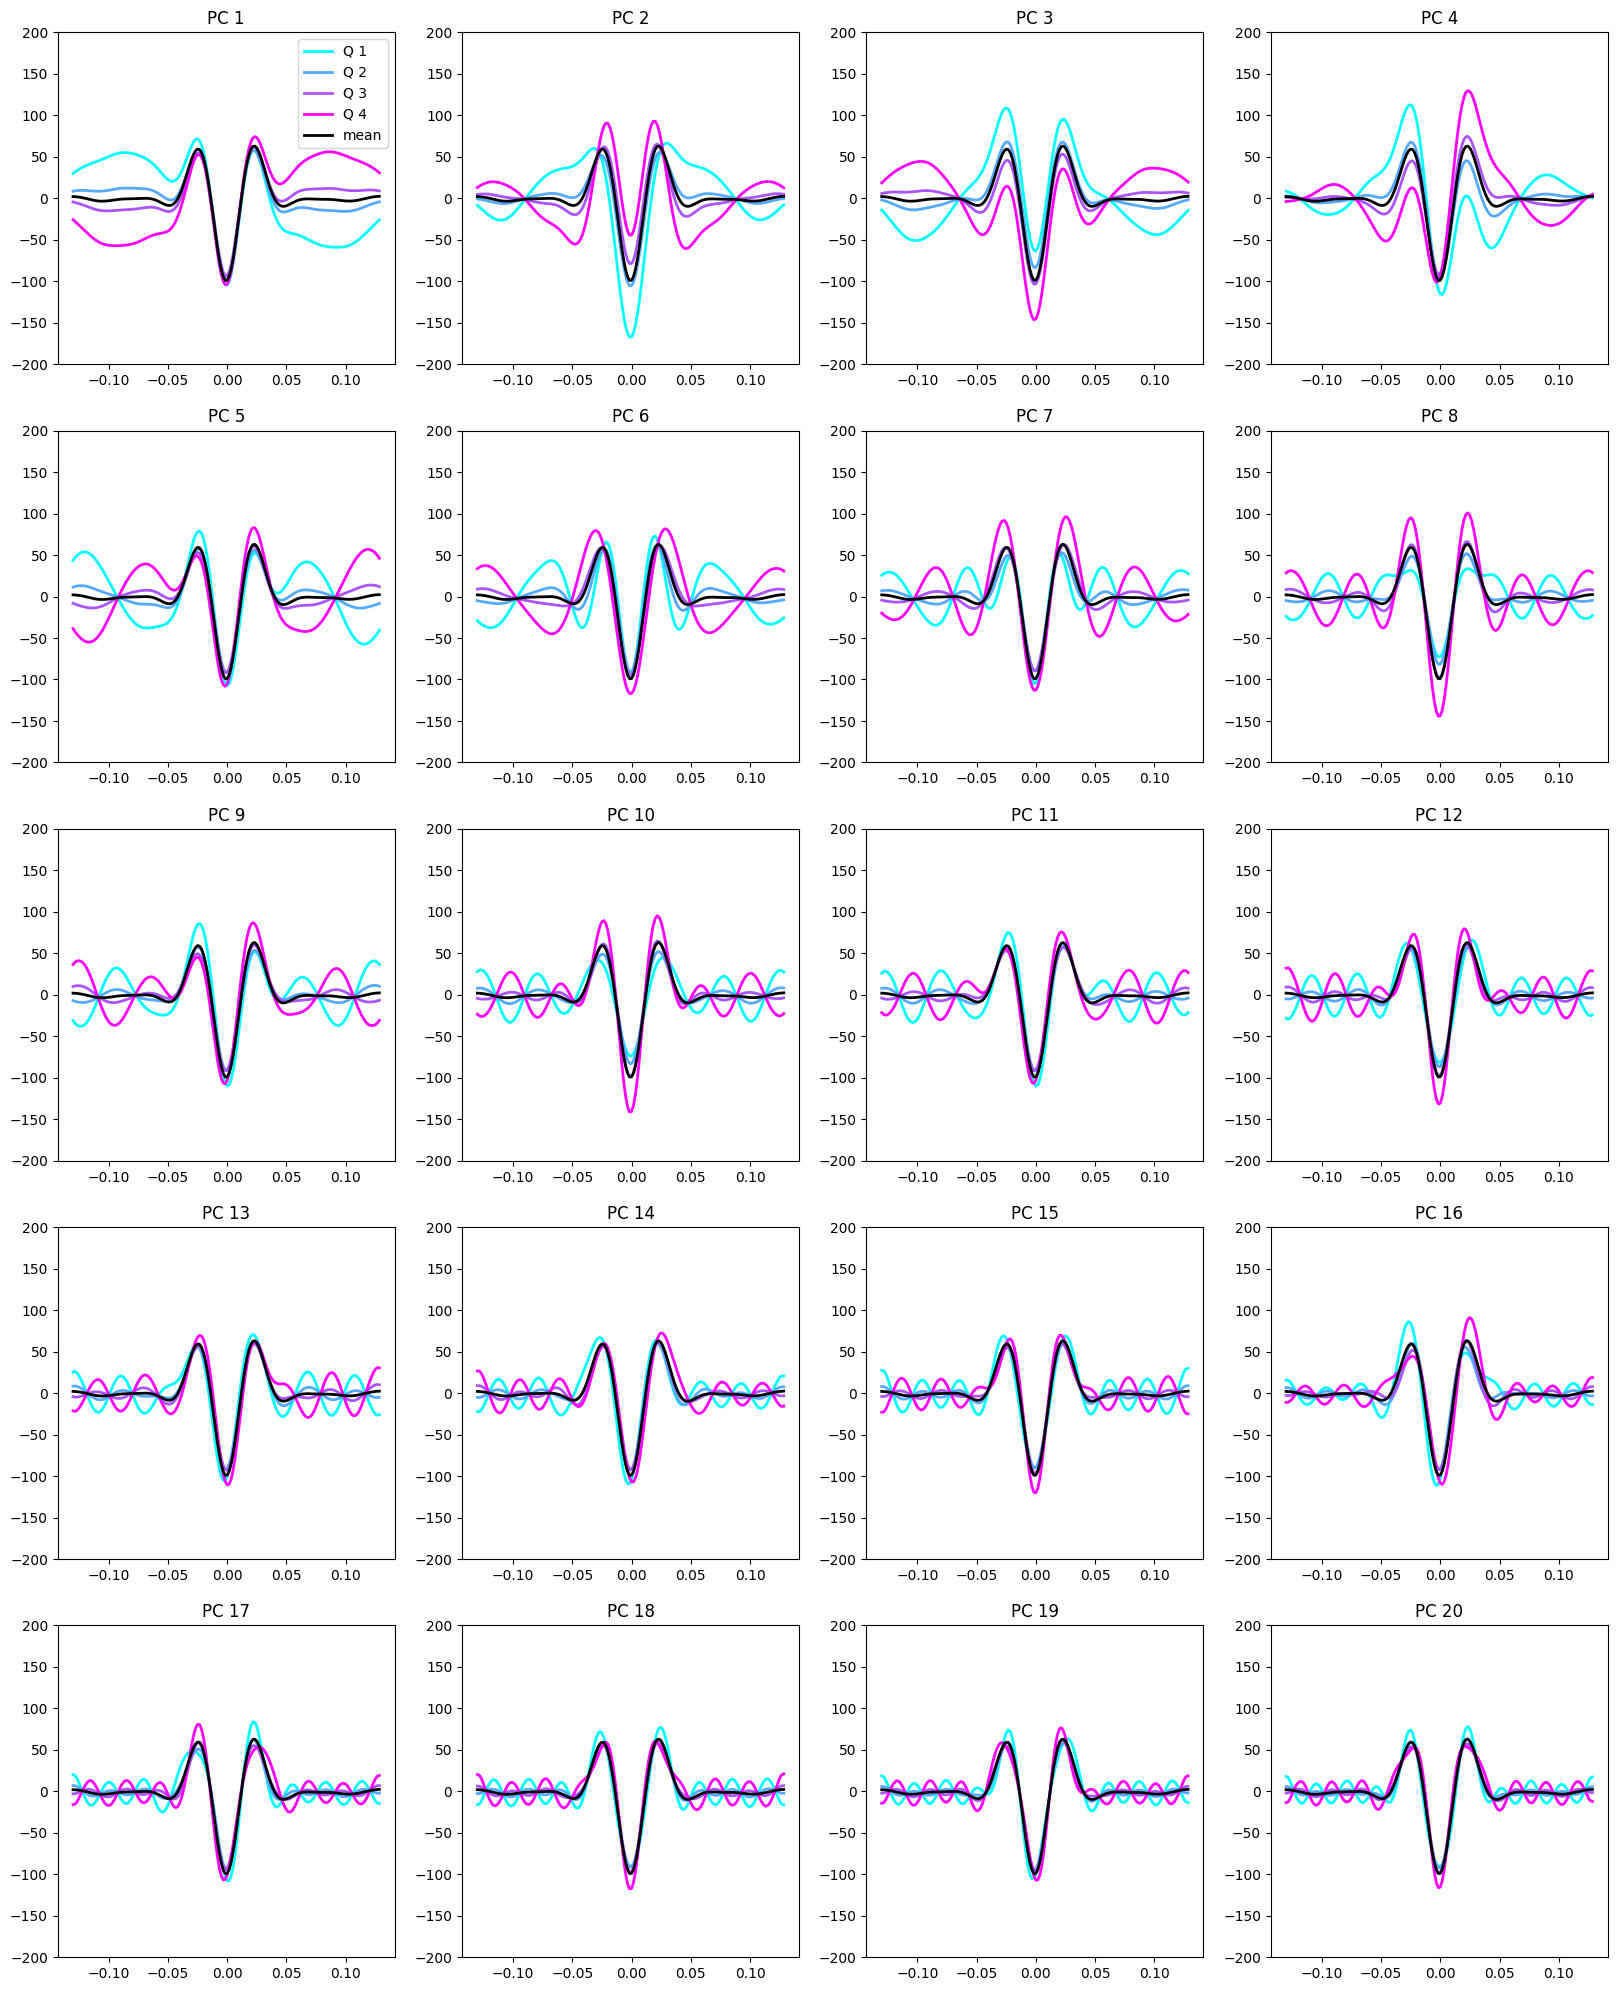

In [80]:
quartiles = np.linspace(0,100, num=5)
quartiles = list(zip(quartiles[:-1], quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0,1, num=len(quartiles)))
mean_waveform = np.mean(waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20,25))
ax = ax.flatten()
for pc_ix, pc in enumerate(pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " ")) # set the nice title
    scores = features_scores[pc].values # select the apropriate principal component from the dataframe
    q_maps = []
    for q_ix, (b,e) in enumerate(quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e)) # create a boolean map to select the waveforms
        q_mean = np.mean(waveforms[q_map], axis=0)
        ax[pc_ix].plot(waveform_times, q_mean/1e-15, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(waveform_times, mean_waveform/1e-15, lw=2, c="black", label="mean")
    ax[pc_ix].set_ylim(-200,200)
ax[0].legend(fontsize=10)